E:\12_AnomalyDetection\test_imgs\QMCG2850_00015_2_0.jpg
Using threshold value: 2.72


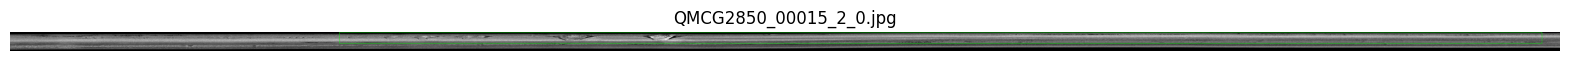

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the saved absolute difference image (in grayscale)
img_path = r"E:\12_AnomalyDetection\localization\QMCG2850_00015_2_0.jpg"
base_name = os.path.basename(img_path)
orig_img_path = os.path.join(r"E:\12_AnomalyDetection\test_imgs", base_name)
print(orig_img_path)

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_orig = cv2.imread(orig_img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError(f"Could not read the image from {img_path}. Check the path.")

# Ensure the images are of type uint8
img = img.astype(np.uint8)
img_orig = img_orig.astype(np.uint8)

# Dynamically determine a threshold to isolate high-value regions.
threshold_value = np.mean(img) + np.std(img)
print(f"Using threshold value: {threshold_value:.2f}")

# Threshold the image: pixels above threshold become white (255), others black.
_, thresh = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY)

# Find contours of the thresholded regions.
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert the images to color for drawing bounding boxes.
# We will draw the bounding box on the original image.
img_orig_color = cv2.cvtColor(img_orig, cv2.COLOR_GRAY2BGR)

# Parameters to filter candidates.
min_area = 50   # Minimum area to avoid very small noise regions.
margin = 10     # Margin in pixels: skip boxes too close to image borders.

# List to store valid square bounding boxes as (x1, y1, x2, y2)
valid_boxes = []

if contours:
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < min_area:
            continue  # Skip small regions

        # Get the bounding rectangle for this contour.
        x, y, w, h = cv2.boundingRect(contour)
        # Filter out elongated regions using aspect ratio.
        aspect_ratio = float(w) / h if h != 0 else 0
        if aspect_ratio < 0.2 or aspect_ratio > 10:
            continue

        # Create a square bounding box based on the larger dimension.
        side = max(w, h)
        center_x = x + w // 2
        center_y = y + h // 2
        new_x = max(center_x - side // 2, 0)
        new_y = max(center_y - side // 2, 0)
        # Adjust if the square would exceed image boundaries.
        if new_x + side > img.shape[1]:
            side = img.shape[1] - new_x
        if new_y + side > img.shape[0]:
            side = img.shape[0] - new_y

        # Skip boxes that are too close to the image borders.
        if new_x < margin or new_y < margin or (new_x + side) > (img.shape[1] - margin) or (new_y + side) > (img.shape[0] - margin):
            continue

        valid_boxes.append((new_x, new_y, new_x + side, new_y + side))

    if valid_boxes:
        # Merge boxes by taking the union of all valid boxes.
        xs = [box[0] for box in valid_boxes]
        ys = [box[1] for box in valid_boxes]
        x2s = [box[2] for box in valid_boxes]
        y2s = [box[3] for box in valid_boxes]

        union_x = min(xs)
        union_y = min(ys)
        union_x2 = max(x2s)
        union_y2 = max(y2s)

        # Compute the union rectangle dimensions.
        union_w = union_x2 - union_x
        union_h = union_y2 - union_y
        
        # Compute additional margin (15% of width and height, respectively).
        extra_margin_x = 0#int(0.15 * union_w)
        extra_margin_y = 0#int(0.15 * union_h)

        # Apply margin and ensure coordinates remain within image bounds.
        final_x = max(union_x - extra_margin_x, 0)
        final_y = max(union_y - extra_margin_y, 0)
        final_x2 = min(union_x2 + extra_margin_x, img.shape[1])
        final_y2 = min(union_y2 + extra_margin_y, img.shape[0])

        # Draw the final bounding box on the original image.
        cv2.rectangle(img_orig_color, (final_x, final_y), (final_x2, final_y2), (0, 255, 0), 2)

        plt.figure(figsize=(20, 8))
        plt.imshow(cv2.cvtColor(img_orig_color, cv2.COLOR_BGR2RGB))
        plt.title(base_name)
        plt.axis("off")
        plt.show()
    else:
        print("No valid isolated anomaly regions detected.")
else:
    print("No high-value anomaly regions detected.")
